In [12]:

# 코랩용 
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

# from matplotlib import font_manager as fm
# import matplotlib.pyplot as plt

# fe = fm.FontEntry(
#     fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
#     name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
# fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
# plt.rcParams.update({'font.size': 14, 'font.family': 'NanumGothic'}) # 폰트 설정

# CNN을 활용한 MNIST 이미지 분류

## #01. 패키지 준비하기

In [20]:
import sys
sys.path.append('../../')
import helper

from pandas import DataFrame
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets.mnist import load_data

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

## #02. 데이터셋 준비하기

In [4]:
(x_train, y_train), (x_test, y_test) = load_data(path='mnist.npz')

## #03. 데이터 전처리

결측치 등의 데이터 이상점이 없는 예제 데이터 이므로 생략

## #04. 탐색적 데이터 분석

이미 앞의 예제를 통해 데이터 형태를 확인하였으므로 생략

## 5) 데이터셋 분할하기

### 랜덤시드 고정

In [5]:
np.random.seed(777)

### 훈련 데이터(독립변수)와 레이블(종속변수) 구분하기

처음부터 데이터 셋이 구분되어 있었으므로 생략

### 훈련 데이터와 검증 데이터로 분할

처음부터 데이터 셋이 구분되어 있었으므로 생략

### 레이블에 대한 one-hot-encoding

In [6]:
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)
print(y_test_one_hot)

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### 훈련, 검증용 독립변수(이미지)의 차수 재설정

기본 CNN 골격에 맞게 28x28x1로 차원을 변경

In [7]:
x_train.shape

(60000, 28, 28)

In [8]:
x_train_reshape = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test_reshape = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
print(f'훈련 데이터 {x_train_reshape.shape} / 검증 데이터 {x_test_reshape.shape}')

훈련 데이터 (60000, 28, 28, 1) / 검증 데이터 (10000, 28, 28, 1)


### 이미지 데이터 정규화

이미지와 같이 복잡한 데이터의 경우 BatchNormalization층을 적용하여 텐서플로우 모델 구성시 표준화를 수행하는 학습층을 추가할 수 있다.

그 경우 독립변수 데이터를 직접 표준화 할 필요가 없다.

ㅁ## 6) 모델 개발

### 모델 정의

(`Conv2D 적용 [-> BatchNormalization층 적용] -> MaxPool2D 적용 [-> Dropout]`)의 과정을 n번 반복 -> Flatten 레이어 추가 -> Dense층 n개 추가

- **Conv2D 층**
    - 영상이나 이미지의 특징을 확인하기 위한 함수
    - `filters`: 필터(커널)의 개수
    - `kernel_size`: 필터의 크기
    - `strides`: 필터의 이동 간격
    - `padding`: valid(패딩 없음), same(인풋과 아웃풋이 같도록 패딩)
    - `activation`: 활성화 함수
    - `input_shape`: 첫 레이어에 인풋으로 들어오는 크기
- **BatchNormalization (배치정규화)**
    - 신경망 입력데이터를 평균 0, 분산 1로 정규화해서 학습이 잘 이루어지도록 하는 방법
    - BatchNormalization 층에서 정규화를 수행하므로 별도의 정규화를 적용할 필요가 없다.
    - 만약 이 층을 적용하지 않는다면 학습 전에 별도의 정규화를 수행하는 것이 좋다.
- **MaxPool2D**
    - 컨볼루션 레이어의 출력 이미지에서 주요값만 뽑아 크기가 작은 출력 영상을 만든다.
    - `pool_size`: 축소시킬 필터의 크기(비율)
    - `strides`: 필터의 이동 간격. 기본값으로 pool_size를 갖는다.
    - 일반적으로 strides는 pool_size와 동일하게 적용되므로 생략하는 편.

In [9]:
model = Sequential()

#------------------------#
# Conv2D
model.add(Conv2D(filters=32, kernel_size=(5, 5), strides=(1, 1), padding='same', activation='relu', input_shape=(28, 28, 1)))

# 표준화
model.add(BatchNormalization())

# MaxPool2D
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

# 랜덤으로 25%의 뉴런을 쉬게함
model.add(Dropout(0.25))
#------------------------#
# 이전보다 filter는 크게, kelnel_size는 작게, input_shape는 최초에만 적용하므로 여기서는 생략
model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
# 랜덤으로 25%의 뉴런을 쉬게함
model.add(Dropout(0.25))
#------------------------#

# 1차원으로 변환하기 위한 Layer --> Dense Layer을 쌓기 전 마지막 처리
model.add(Flatten())

model.add(Dense(512, activation='relu'))

# 최종 아웃풋의 수는 one_hot_encoding의 원소 수 만큼
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 batch_normalization (Batch  (None, 28, 28, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 64)        2

### 학습하기

In [10]:
result = model.fit(x_train_reshape, y_train_one_hot, epochs=500, validation_data=(x_test_reshape, y_test_one_hot), callbacks = [
    EarlyStopping(monitor = 'val_loss', patience=5, verbose = 1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.0001, verbose=1)
])

Epoch 1/500


1875/1875 [==============================] - 91s 48ms/step - loss: 0.1525 - acc: 0.9593 - val_loss: 0.0577 - val_acc: 0.9833 - lr: 0.0010
Epoch 2/500
1875/1875 [==============================] - 95s 51ms/step - loss: 0.0604 - acc: 0.9820 - val_loss: 0.0369 - val_acc: 0.9893 - lr: 0.0010
Epoch 3/500
1875/1875 [==============================] - 81s 43ms/step - loss: 0.0510 - acc: 0.9852 - val_loss: 0.0496 - val_acc: 0.9861 - lr: 0.0010
Epoch 4/500
1875/1875 [==============================] - 86s 46ms/step - loss: 0.0395 - acc: 0.9890 - val_loss: 0.0355 - val_acc: 0.9896 - lr: 0.0010
Epoch 5/500
1875/1875 [==============================] - 80s 42ms/step - loss: 0.0371 - acc: 0.9893 - val_loss: 0.0464 - val_acc: 0.9861 - lr: 0.0010
Epoch 6/500
1875/1875 [==============================] - 78s 42ms/step - loss: 0.0307 - acc: 0.9912 - val_loss: 0.0453 - val_acc: 0.9899 - lr: 0.0010
Epoch 7/500
1874/1875 [============================>.] - ETA: 0s - loss: 0.0290 - acc: 0.9914
Epoch 7: ReduceLRO

## #07. 학습 결과 평가

In [28]:
def tf_result_plot(result, figsize=(15, 5), dpi=150):
    # 학습 결과에 대한 데이터프레임 생성
    result_df = DataFrame(result.history)
    result_df['epochs'] = result_df.index+1
    result_df.set_index('epochs', inplace=True)
    
    # 학습 결과 그래프의 컬럼명
    column_names = result_df.columns
    
    # 학습데이터에 대한 필드이름
    train_column_name = [column_names[0], column_names[1]]
    
    # 검증데이터에 대한 필드이름
    test_column_name = [column_names[2], column_names[3]]
    
    # 학습 결과 그래프
    fig, ax = plt.subplots(1, 2, figsize=figsize, dpi=dpi)
    
    for i, v in enumerate(ax):
        sb.lineplot(x=result_df.index, y=train_column_name[i], data=result_df, color='blue', label=train_column_name[i], ax=v)
        sb.lineplot(x=result_df.index, y=test_column_name[i], data=result_df, color='orange', label=test_column_name[i], ax=v)
        v.set_title(train_column_name[i])
        v.set_xlabel('ephocs')
        v.set_ylabel(train_column_name[i])
        v.grid()
        v.legend()
    
    plt.show()
    plt.close()
    
    return result_df


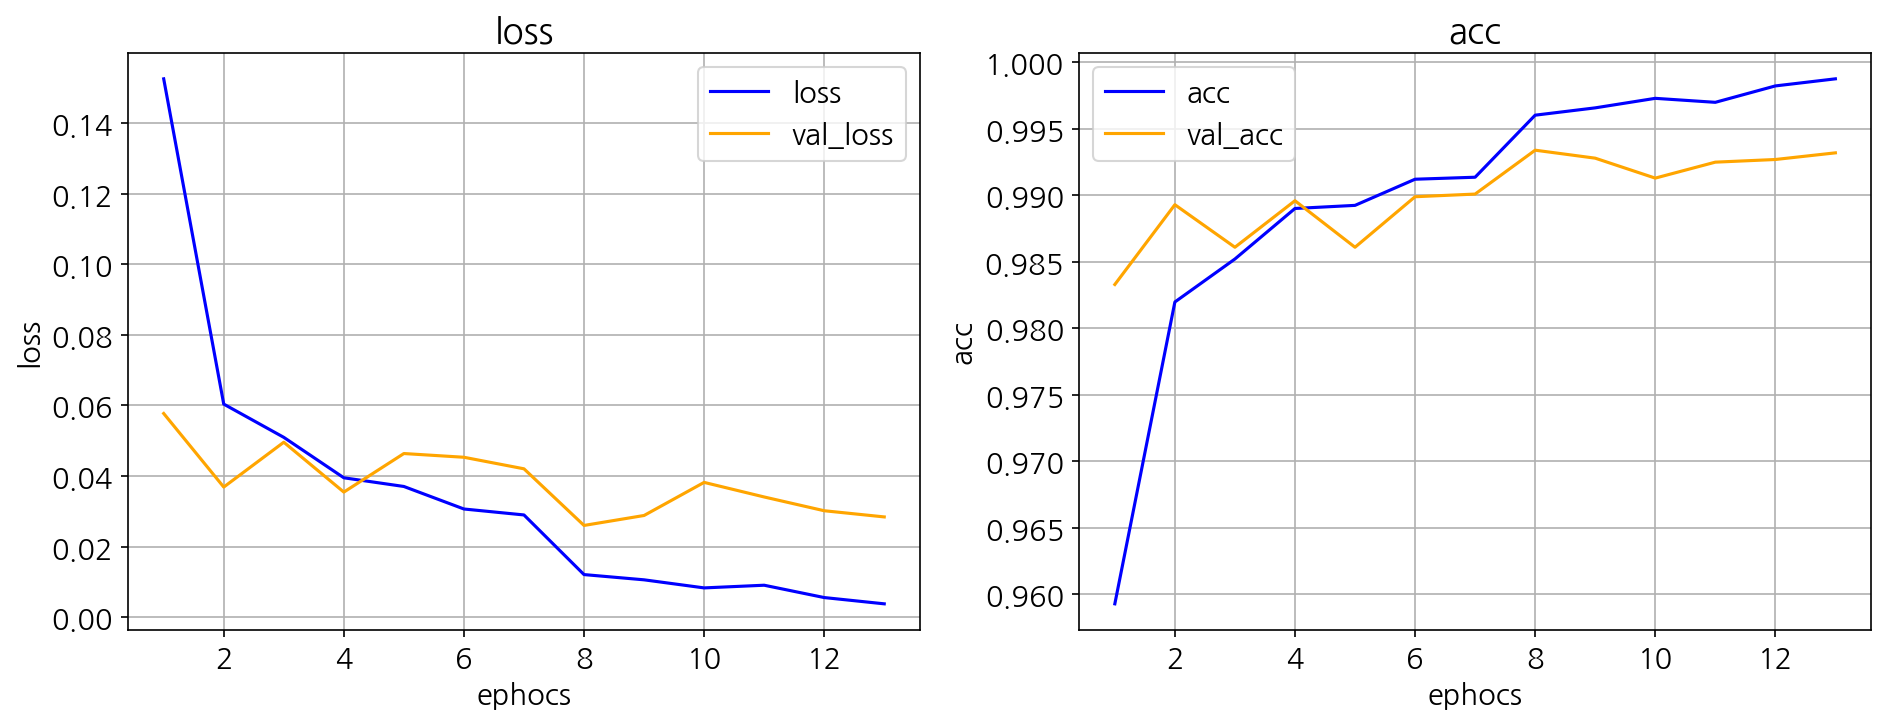

1875/1875 [==============================] - 14s 8ms/step - loss: 6.4841e-04 - acc: 0.9998
최종 훈련 손실률: 0.000648, 최종 훈련 정확도: 0.999833
313/313 [==============================] - 2s 7ms/step - loss: 0.0284 - acc: 0.9932
최종 검증 손실률: 0.028428, 최종 검증 정확도: 0.993200


In [30]:
tf_result_plot(result)

evaluate1 = model.evaluate(x_train_reshape, y_train_one_hot)
print("최종 훈련 손실률: %f, 최종 훈련 정확도: %f" % (evaluate1[0], evaluate1[1]))

evaluate2 = model.evaluate(x_test_reshape, y_test_one_hot)
print("최종 검증 손실률: %f, 최종 검증 정확도: %f" % (evaluate2[0], evaluate2[1]))

## 8) 학습 결과 적용

### 훈련 데이터에 대한 예측 결과 산정

In [34]:
result = model.predict(x_train_reshape)
data_count, case_count = result.shape
print("%d개의 검증 데이터가 %d개의 경우의 수를 갖는다." % (data_count, case_count))
result[0]

1875/1875 [==============================] - 14s 7ms/step
60000개의 검증 데이터가 10개의 경우의 수를 갖는다.


array([3.21334768e-21, 1.43690901e-17, 1.42254922e-24, 1.18056356e-07,
       9.97973315e-22, 9.99999881e-01, 3.80258402e-17, 1.75905996e-18,
       1.43674677e-14, 3.63963654e-14], dtype=float32)

### 가장 큰 확률 값의 인덱스를 별도 리스트로 추출

In [31]:
arg_result = np.argmax(result, axis=-1)
arg_result

0

### 데이터 비교

IndexError: invalid index to scalar variable.

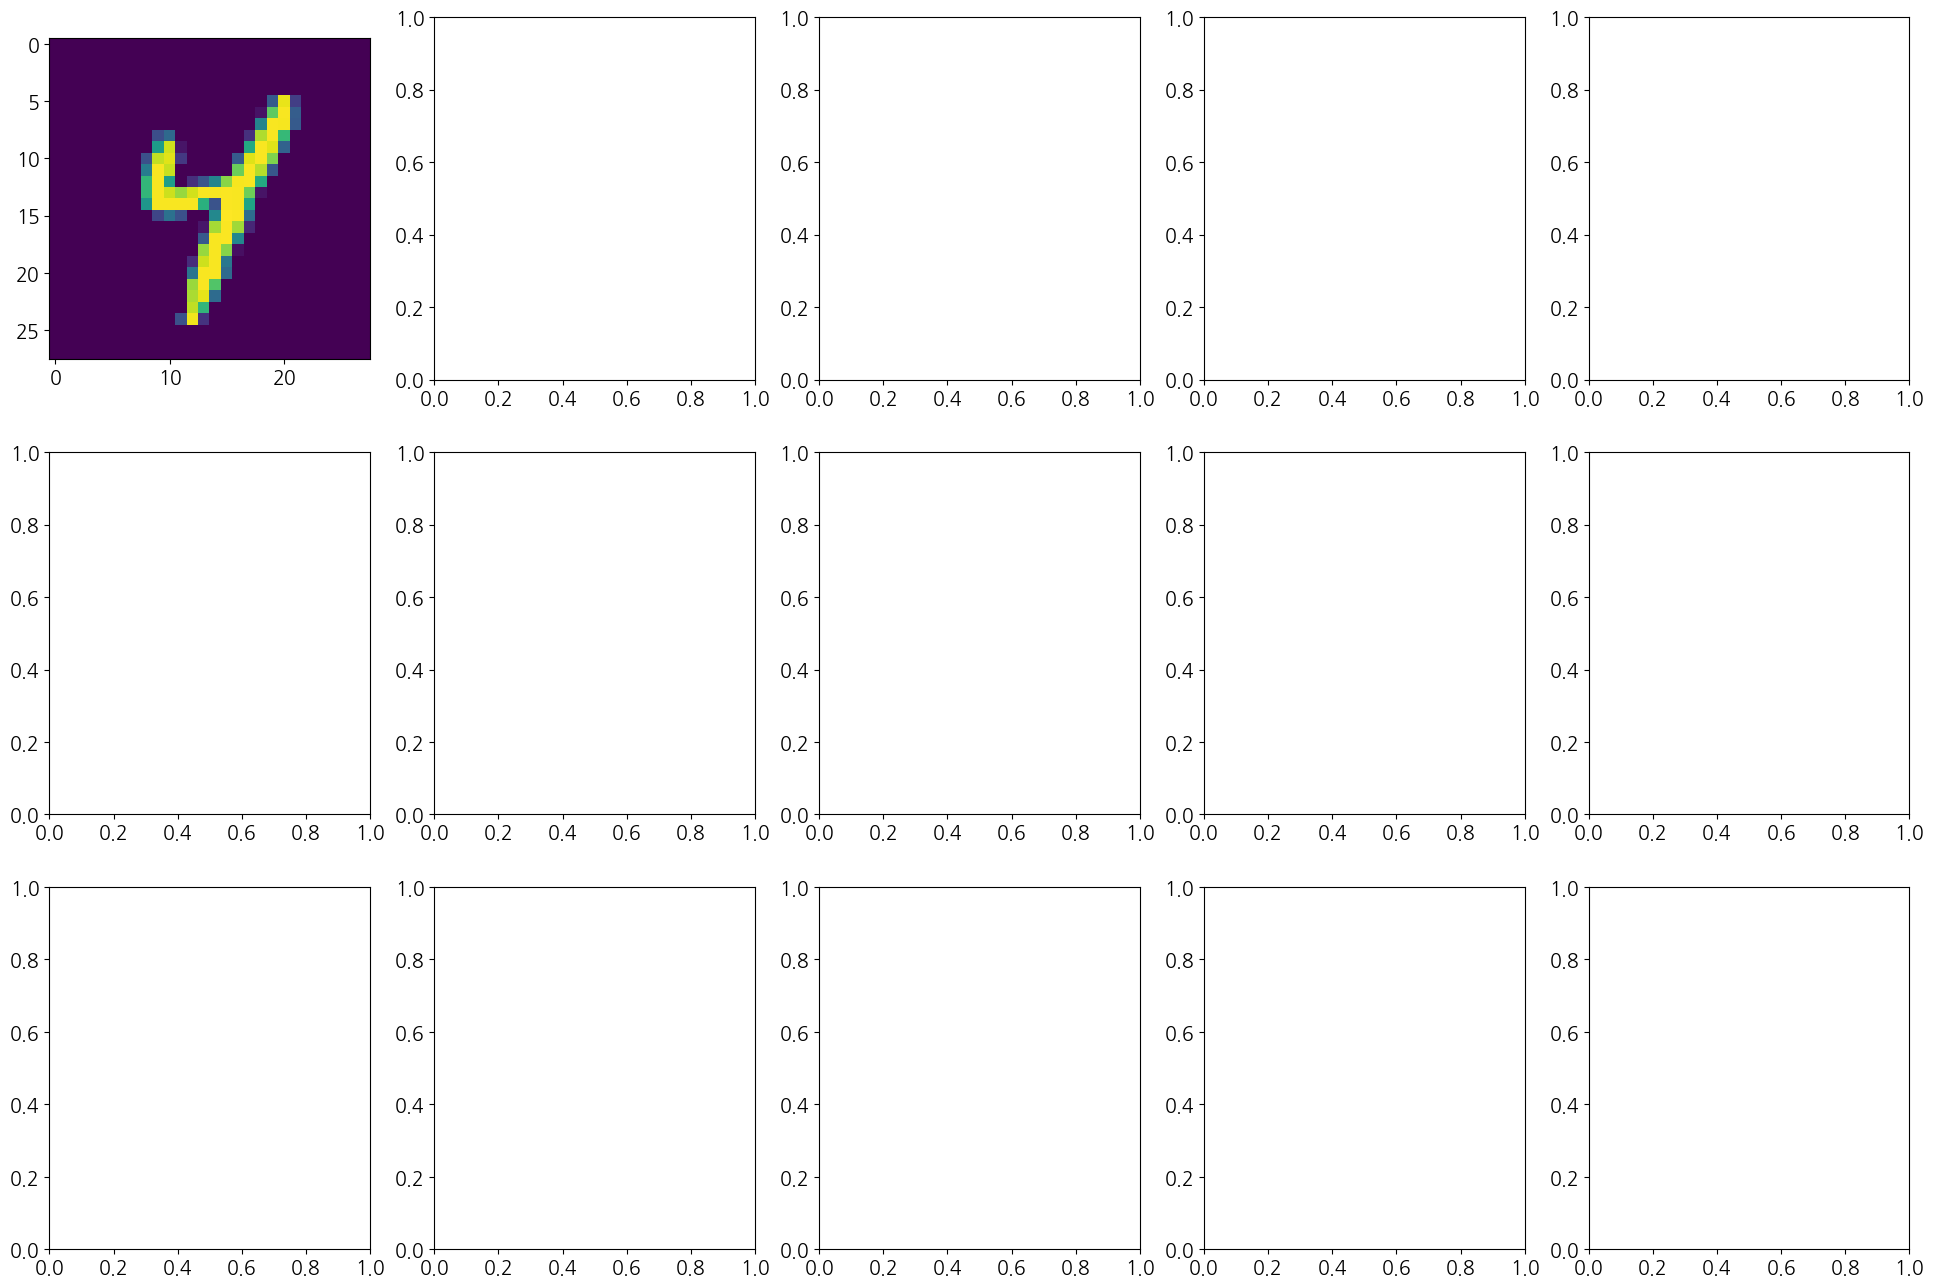

In [32]:
row = 3
col = 5
fig, ax = plt.subplots(row, col, figsize=((col+1)*4, (row+1)*4), dpi=100)

size = row*col
length = len(y_train)

for i in range(0, size):
    k = np.random.randint(length)
    train = x_train[k]
    label = y_train[k]
    ax[i//col][i%col].imshow(train)
    ax[i//col][i%col].set_title("label=%d, LM=%d" % (label, arg_result[k]))

plt.show()
plt.close()

### 혼동행렬

In [33]:
cm = confusion_matrix(y_train, arg_result)
cmdf2 = DataFrame(cm, columns=list(map(lambda x: "실제값(%d)" % x, range(10))), index=list(map(lambda x: "예측값(%d)" % x, range(10))))
cmdf2

InvalidParameterError: The 'y_pred' parameter of confusion_matrix must be an array-like. Got 0 instead.

### 혼동행렬 히트맵

In [24]:
plt.figure(figsize=(15, 10))
sb.heatmap(cmdf2, annot = True, fmt = 'd', cmap = 'Blues')
plt.xlabel('결과값')
plt.ylabel('예측값')
plt.show()
plt.close()

NameError: name 'cmdf2' is not defined

<Figure size 1500x1000 with 0 Axes>